# Child Mind Institute — Problematic Internet Use - Kaggle Competition

## Overview

Can you predict the level of problematic internet usage exhibited by children and adolescents, based on their physical activity? The goal of this competition is to develop a predictive model that analyzes children's physical activity and fitness data to identify early signs of problematic internet use. Identifying these patterns can help trigger interventions to encourage healthier digital habits.

## Description

In today’s digital age, problematic internet use among children and adolescents is a growing concern. Better understanding this issue is crucial for addressing mental health problems such as depression and anxiety.

Current methods for measuring problematic internet use in children and adolescents are often complex and require professional assessments. This creates access, cultural, and linguistic barriers for many families. Due to these limitations, problematic internet use is often not measured directly, but is instead associated with issues such as depression and anxiety in youth.

Conversely, physical & fitness measures are extremely accessible and widely available with minimal intervention or clinical expertise. Changes in physical habits, such as poorer posture, irregular diet, and reduced physical activity, are common in excessive technology users. We propose using these easily obtainable physical fitness indicators as proxies for identifying problematic internet use, especially in contexts lacking clinical expertise or suitable assessment tools.

This competition challenges you to develop a predictive model capable of analyzing children's physical activity data to detect early indicators of problematic internet and technology use. This will enable prompt interventions aimed at promoting healthier digital habits.

Your work will contribute to a healthier, happier future where children are better equipped to navigate the digital landscape responsibly.

## Analysis

### Load and Summarise Data

Begin by loading the train and tests sets:

In [1]:
import pandas as pd
import os
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=FutureWarning)
SEED = 42
np.random.seed(SEED)
import random
random.seed(SEED)
import os
os.environ["PYTHONHASHSEED"] = str(SEED)

# Define the base path to the data directory
data_dir = '../data/child-mind-institute-problematic-internet-use/'

# Load the CSV files
train_csv_path = os.path.join(data_dir, 'train.csv')
test_csv_path = os.path.join(data_dir, 'test.csv')
data_dict_path = os.path.join(data_dir, 'data_dictionary.csv')

train = pd.read_csv(train_csv_path)
test = pd.read_csv(test_csv_path)
data_dict = pd.read_csv(data_dict_path)

# Separate target variable from training data
train_y = train['sii']  # Target variable
train.drop(columns=['sii'], inplace=True)

# Ensure only columns present in both train and test are used
common_columns = list(set(train.columns).intersection(set(test.columns)))
train = train[common_columns]
test = test[common_columns]

# Add back the target variable to train
train['sii'] = train_y

# Drop rows where target is missing
train = train.query("~sii.isna()")

# Verify columns
print("Columns in training data:", train.columns)
print("Columns in test data:", test.columns)

# Ensure shapes are consistent
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Columns in training data: Index(['Physical-Season', 'BIA-BIA_SMM', 'PAQ_A-PAQ_A_Total', 'BIA-BIA_FMI',
       'SDS-SDS_Total_T', 'Basic_Demos-Age', 'FGC-FGC_SRL_Zone',
       'Physical-BMI', 'PAQ_C-Season', 'FGC-FGC_PU_Zone', 'BIA-BIA_BMI',
       'FGC-FGC_SRR_Zone', 'BIA-BIA_LST', 'FGC-FGC_GSND_Zone', 'FGC-FGC_TL',
       'FGC-FGC_GSND', 'Fitness_Endurance-Time_Mins', 'BIA-BIA_ICW',
       'BIA-Season', 'FGC-FGC_SRR', 'Physical-Height', 'SDS-SDS_Total_Raw',
       'SDS-Season', 'BIA-BIA_TBW', 'BIA-BIA_Fat', 'Basic_Demos-Enroll_Season',
       'id', 'BIA-BIA_Frame_num', 'Fitness_Endurance-Time_Sec',
       'FGC-FGC_TL_Zone', 'BIA-BIA_DEE', 'Fitness_Endurance-Season',
       'BIA-BIA_BMC', 'PreInt_EduHx-Season', 'CGAS-CGAS_Score',
       'FGC-FGC_GSD_Zone', 'BIA-BIA_ECW', 'Fitness_Endurance-Max_Stage',
       'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'FGC-FGC_PU',
       'Physical-HeartRate', 'FGC-FGC_CU', 'Physical-Waist_Circumference',
       'PAQ_C-PAQ_C_Total', 'Basic_Demos-S

In [2]:

# Check basic information
print("Train Data Overview")
print(train.info())
print("\nTest Data Overview")
print(test.info())

# Check missing values
print("\nMissing Values in Train Data")
print(train.isnull().sum())

print("\nTarget Distribution (sii)")
print(train['sii'].value_counts(normalize=True))

# Data dictionary overview
print("\nData Dictionary Sample")
print(data_dict.head())

Train Data Overview
<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 60 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Physical-Season                         2595 non-null   object 
 1   BIA-BIA_SMM                             1813 non-null   float64
 2   PAQ_A-PAQ_A_Total                       363 non-null    float64
 3   BIA-BIA_FMI                             1813 non-null   float64
 4   SDS-SDS_Total_T                         2525 non-null   float64
 5   Basic_Demos-Age                         2736 non-null   int64  
 6   FGC-FGC_SRL_Zone                        1877 non-null   float64
 7   Physical-BMI                            2527 non-null   float64
 8   PAQ_C-Season                            1440 non-null   object 
 9   FGC-FGC_PU_Zone                         1875 non-null   float64
 10  BIA-BIA_BMI                             1813 

Load the activity data iterating through parquet files:

In [3]:
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Base directories
series_train_dir = '../data/child-mind-institute-problematic-internet-use/series_train.parquet/'
series_test_dir = '../data/child-mind-institute-problematic-internet-use/series_test.parquet/'

# Function to process a single file
def process_file(filename, dirname):
    # Construct path to the specific Parquet file
    file_path = os.path.join(dirname, filename, 'part-0.parquet')
    
    # Load the Parquet file
    try:
        df = pd.read_parquet(file_path)
        
        # Drop unnecessary columns and compute summaries
        df.drop('step', axis=1, inplace=True, errors='ignore')  # Drop 'step' if it exists
        summary = {
            'mean_enmo': df['enmo'].mean(),
            'std_enmo': df['enmo'].std(),
            'mean_light': df['light'].mean(),
            'std_light': df['light'].std(),
            'wear_time_percentage': 100 * (1 - df['non-wear_flag'].mean()),
            'anglez_mean': df['anglez'].mean(),
            'anglez_std': df['anglez'].std(),
        }
        return summary, filename.split('=')[1]  # Extract ID from directory name
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

# Function to filter valid directories
def valid_id_dirs(dirname):
    ids = os.listdir(dirname)
    return [f for f in ids if not f.startswith('.') and os.path.isdir(os.path.join(dirname, f))]

# Function to load and summarize time-series data
def load_time_series(dirname) -> pd.DataFrame:
    ids = valid_id_dirs(dirname)  # Exclude hidden files/directories
    
    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    # Process valid results
    stats, indexes = zip(*[res for res in results if res[0] is not None])
    df = pd.DataFrame(stats)
    df['id'] = indexes
    return df

# Load and summarize the time-series data for train and test
print("Processing training activity data...")
time_series_train_summary = load_time_series(series_train_dir)

print("Processing test activity data...")
time_series_test_summary = load_time_series(series_test_dir)

# Display the summaries
print("\nTraining Activity Summary:")
print(time_series_train_summary.head())

print("\nTest Activity Summary:")
print(time_series_test_summary.head())

Processing training activity data...


100%|██████████| 996/996 [00:07<00:00, 134.15it/s]


Processing test activity data...


100%|██████████| 2/2 [00:00<00:00, 109.36it/s]


Training Activity Summary:
   mean_enmo  std_enmo  mean_light   std_light  wear_time_percentage  \
0   0.061542  0.129369   41.468441  180.046051            100.000000   
1   0.023465  0.052369   68.818016  278.520935             78.347546   
2   0.004798  0.027894    9.674905   47.171303             38.881731   
3   0.045412  0.095615  132.968567  434.872345            100.000000   
4   0.018893  0.075737   10.622702   39.840015             34.234810   

   anglez_mean  anglez_std        id  
0   -14.676989   28.848204  0d01bbf2  
1   -18.722479   49.600796  cefdb7fe  
2   -21.601578   67.857338  58391429  
3   -17.783920   25.641258  2ca2206f  
4   -30.760855   53.359848  19455336  

Test Activity Summary:
   mean_enmo  std_enmo  mean_light   std_light  wear_time_percentage  \
0   0.011926  0.024331   16.771982   95.327438             34.429204   
1   0.047388  0.106351   42.296310  208.168976            100.000000   

   anglez_mean  anglez_std        id  
0   -55.630768   50.30363

In [4]:
print(time_series_train_summary.shape)
print(time_series_test_summary.shape)


(996, 8)
(2, 8)


Join the activity and characteristic data together

In [5]:
# Merge time series summary with train data
train_merged = pd.merge(train, time_series_train_summary, on='id', how='left')

# Merge time series summary with test data
test_merged = pd.merge(test, time_series_test_summary, on='id', how='left')

# Check the merged DataFrames
print("Merged Train DataFrame Shape:", train_merged.shape)
print(train_merged.shape)

print("\nMerged Test DataFrame Shape:", test_merged.shape)
print(test_merged.shape)


Merged Train DataFrame Shape: (2736, 67)
(2736, 67)

Merged Test DataFrame Shape: (20, 66)
(20, 66)


Drop any columns the target is derived from and not available in the test set.

### Exploratory Data Analysis

Identify and deal with missing data

In [6]:
print("Train missing data: ", train_merged.isna().sum())
print("Test missing data: ", test_merged.isna().sum())

Train missing data:  Physical-Season          141
BIA-BIA_SMM              923
PAQ_A-PAQ_A_Total       2373
BIA-BIA_FMI              923
SDS-SDS_Total_T          211
                        ... 
mean_light              1740
std_light               1740
wear_time_percentage    1740
anglez_mean             1740
anglez_std              1740
Length: 67, dtype: int64
Test missing data:  Physical-Season          6
BIA-BIA_SMM             12
PAQ_A-PAQ_A_Total       19
BIA-BIA_FMI             12
SDS-SDS_Total_T         10
                        ..
mean_light              18
std_light               18
wear_time_percentage    18
anglez_mean             18
anglez_std              18
Length: 66, dtype: int64


In [7]:
# Handle missing values for training set
# Fill numeric columns with their median
train_numeric_columns = train_merged.select_dtypes(include=['number']).columns
train_merged[train_numeric_columns] = train_merged[train_numeric_columns].apply(
    lambda col: col.fillna(col.median()), axis=0
)

# Fill categorical columns with their most frequent value (mode)
train_categorical_columns = train_merged.select_dtypes(include=['object']).columns
train_merged[train_categorical_columns] = train_merged[train_categorical_columns].fillna(
    train_merged[train_categorical_columns].mode().iloc[0]
)

# Handle missing values for test set
# Fill numeric columns with their median
test_numeric_columns = test_merged.select_dtypes(include=['number']).columns
test_merged[test_numeric_columns] = test_merged[test_numeric_columns].apply(
    lambda col: col.fillna(col.median()), axis=0
)

# Fill categorical columns with their most frequent value (mode)
test_categorical_columns = test_merged.select_dtypes(include=['object']).columns
test_merged[test_categorical_columns] = test_merged[test_categorical_columns].fillna(
    test_merged[test_categorical_columns].mode().iloc[0]
)


Analyse correlations

In [8]:
# Ensure numeric columns include the derived features
numeric_cols = train_merged.select_dtypes(include=['number'])

# Add back 'sii' for correlation calculation
numeric_cols['sii'] = train_merged['sii']

# Compute correlations with the target
correlation_with_target = numeric_cols.corr()['sii'].sort_values(ascending=False)

print("\nCorrelation of Features with Target (sii):")
print(correlation_with_target)  # Top 20 correlations




Correlation of Features with Target (sii):
sii                                       1.000000
Basic_Demos-Age                           0.365990
Physical-Height                           0.360802
PreInt_EduHx-computerinternet_hoursday    0.331288
Physical-Weight                           0.316121
SDS-SDS_Total_T                           0.221783
SDS-SDS_Total_Raw                         0.218960
Physical-BMI                              0.214107
FGC-FGC_CU                                0.200546
BIA-BIA_BMI                               0.181326
FGC-FGC_GSD                               0.142892
FGC-FGC_GSND                              0.141831
BIA-BIA_Frame_num                         0.133906
FGC-FGC_PU                                0.132108
Physical-Systolic_BP                      0.130629
Physical-Waist_Circumference              0.099125
FGC-FGC_TL                                0.088465
BIA-BIA_FFMI                              0.082325
BIA-BIA_FMI                           

1. Top Positive Correlations:
    + Features like `Physical-Height`, `Basic_Demos-Age`, and `PreInt_EduHx-computerinternet_hoursday` have moderate positive correlations with `sii`. 
    + These suggest older participants and those who spend more time on the internet daily may have higher `sii` values.

2. Negative Correlations with Activity Metrics:
    + `mean_enmo` and `std_enmo` have moderate negative correlations with `sii`: 
        - Interpretation: Lower physical activity and variability in activity might indicate higher levels of problematic internet use.
    + `wear_time_percentage` also has a slight negative correlation, which could indicate that participants with lower device wear time might have higher `sii` values (potentially due to sedentary behavior).

3. Light Metrics:
    + `mean_light` and `std_light` show weak negative correlations, which might reflect less outdoor activity in participants with higher `sii`.

### Feature Engineering

#### Time-series Activity Patterns

In [9]:

import os
import pandas as pd
from tqdm import tqdm

# Base directories for activity data
series_train_dir = '../data/child-mind-institute-problematic-internet-use/series_train.parquet/'
series_test_dir = '../data/child-mind-institute-problematic-internet-use/series_test.parquet/'

# Function to extract time-of-day features from a participant's data
def extract_time_of_day_features(data):
    # Extract hour and time bins
    data['hour'] = pd.to_datetime(data['time_of_day']).dt.hour
    time_bins = [0, 6, 12, 18, 24]  # Night, Morning, Afternoon, Evening
    time_labels = ['Night', 'Morning', 'Afternoon', 'Evening']
    data['time_of_day_bin'] = pd.cut(data['hour'], bins=time_bins, labels=time_labels, right=False)

    # Aggregate activity by time of day with prefixed column names
    features = data.groupby('time_of_day_bin').agg(
        mean_enmo=('enmo', 'mean'),
        std_enmo=('enmo', 'std'),
        mean_light=('light', 'mean'),
        std_light=('light', 'std')
    ).reset_index()
    
    # Add prefix to columns
    features.columns = ['time_of_day_bin'] + [f"time_of_day_{col}" for col in features.columns[1:]]
    return features

# Function to process time-of-day features for all participants
def process_time_of_day(dirname):
    time_of_day_features = []

    # Filter valid directories
    valid_dirs = [f for f in os.listdir(dirname) if not f.startswith('.') and os.path.isdir(os.path.join(dirname, f))]

    for id_dir in tqdm(valid_dirs, desc=f"Processing activity data from {dirname}"):
        participant_path = os.path.join(dirname, id_dir, 'part-0.parquet')
        if not os.path.exists(participant_path):  # Skip invalid directories/files
            continue

        # Load participant data
        participant_data = pd.read_parquet(participant_path)

        # Extract time-of-day features
        time_features = extract_time_of_day_features(participant_data)
        time_features['id'] = id_dir.split('=')[1]  # Add participant ID
        time_of_day_features.append(time_features)

    # Combine all participants' time-of-day features into a single DataFrame
    combined = pd.concat(time_of_day_features, ignore_index=True)

    # Collapse to a single row per participant (summarize across time-of-day bins)
    collapsed = combined.drop(columns=['time_of_day_bin']).groupby('id').mean().reset_index()
    return collapsed

# Process training activity data
print("Processing training activity data...")
train_time_of_day_features = process_time_of_day(series_train_dir)

# Merge with the train set
train_merged = pd.merge(train, train_time_of_day_features, on='id', how='left')

# Process test activity data
print("\nProcessing test activity data...")
test_time_of_day_features = process_time_of_day(series_test_dir)

# Merge with the test set
test_merged = pd.merge(test, test_time_of_day_features, on='id', how='left')

# Final previews
print("\nTrain Data with Time-of-Day Features:")
#print(train_merged.head())

print("\nTest Data with Time-of-Day Features:")
#print(test_merged.head())

train_merged.head()


Processing training activity data...


Processing activity data from ../data/child-mind-institute-problematic-internet-use/series_train.parquet/: 100%|██████████| 996/996 [01:31<00:00, 10.85it/s]



Processing test activity data...


Processing activity data from ../data/child-mind-institute-problematic-internet-use/series_test.parquet/: 100%|██████████| 2/2 [00:00<00:00, 14.56it/s]


Train Data with Time-of-Day Features:

Test Data with Time-of-Day Features:


,Physical-Season,BIA-BIA_SMM,PAQ_A-PAQ_A_Total,BIA-BIA_FMI,SDS-SDS_Total_T,Basic_Demos-Age,FGC-FGC_SRL_Zone,Physical-BMI,PAQ_C-Season,FGC-FGC_PU_Zone,...,FGC-Season,FGC-FGC_GSD,PreInt_EduHx-computerinternet_hoursday,BIA-BIA_BMR,BIA-BIA_LDM,sii,time_of_day_mean_enmo,time_of_day_std_enmo,time_of_day_mean_light,time_of_day_std_light
0,Fall,19.5413,NaN,3.06143,NaN,5,0.0,16.877316,NaN,0.0,...,Fall,NaN,3.0,932.498,8.89536,2.0,NaN,NaN,NaN,NaN
1,Fall,15.4107,NaN,1.21172,64.0,9,1.0,14.035590,Fall,0.0,...,Fall,NaN,0.0,936.656,14.97400,0.0,NaN,NaN,NaN,NaN
2,Fall,NaN,NaN,NaN,54.0,10,1.0,16.648696,Summer,1.0,...,Fall,14.7,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,Summer,26.4798,NaN,4.22033,45.0,9,0.0,18.292347,Winter,0.0,...,Summer,NaN,0.0,1131.430,16.77900,1.0,0.043147,0.086003,37.345001,147.249176
4,Summer,35.3804,NaN,13.49880,56.0,13,1.0,22.279952,Spring,0.0,...,Summer,17.9,0.0,1330.970,20.90200,1.0,0.011928,0.022127,16.807493,68.106743


In [10]:
print(train_merged.shape)
print(test_merged.shape)

(2736, 64)
(20, 63)


In [11]:
# Define a small constant to prevent division by zero
epsilon = 1e-6

# === Process Test Activity Data ===
print("\nProcessing test activity data...")
test_activity_summary = load_time_series(series_test_dir)  # Ensure load_time_series is defined

# === Process Time-of-Day Features for Test Set ===
print("\nProcessing time-of-day features for test data...")
test_time_of_day_features = process_time_of_day(series_test_dir)  # Use the same process_time_of_day function

# === Merge Activity and Time-of-Day Features into Test Set ===
print("\nMerging test activity and time-of-day features...")
# Merge activity summaries
test_merged = pd.merge(test, test_activity_summary, on='id', how='left')  
# Merge time-of-day features
test_merged = pd.merge(test_merged, test_time_of_day_features, on='id', how='left')  

# Drop duplicate or redundant columns in the test set
test_columns_to_drop = ['mean_enmo_y', 'std_enmo_y', 'mean_light_y', 'std_light_y']
test_merged = test_merged.drop(columns=test_columns_to_drop, errors='ignore')

# Rename remaining columns for clarity (if needed)
test_merged.rename(columns={'mean_enmo_x': 'mean_enmo', 'std_enmo_x': 'std_enmo'}, inplace=True)

# Verify the test DataFrame after merging
print("Columns in test_merged after merging and cleaning duplicates:")
print(test_merged.columns)

# === Apply Feature Engineering to the Test Set ===
# Demographic Features
print("\nApplying demographic feature engineering to test set...")
test_merged['age_squared'] = test_merged['Basic_Demos-Age'] ** 2
test_merged['age_sex_interaction'] = test_merged['Basic_Demos-Age'] * test_merged['Basic_Demos-Sex']

# Health Features
print("\nApplying health feature engineering to test set...")
test_merged['height_weight_ratio'] = test_merged['Physical-Height'] / (test_merged['Physical-Weight'] + 1)

# Standardize heart rate using train statistics
train_heart_rate_mean = train_merged['Physical-HeartRate'].mean()
train_heart_rate_std = train_merged['Physical-HeartRate'].std()
test_merged['standardized_heart_rate'] = (
    test_merged['Physical-HeartRate'] - train_heart_rate_mean
) / train_heart_rate_std

# Systolic to Diastolic ratio
test_merged['systolic_diastolic_ratio'] = (
    test_merged['Physical-Systolic_BP'] / (test_merged['Physical-Diastolic_BP'] + 1)
)

# Internet Usage Features
print("\nApplying internet usage feature engineering to test set...")
test_merged['internet_hours_age_interaction'] = (
    test_merged['PreInt_EduHx-computerinternet_hoursday'] * test_merged['Basic_Demos-Age']
)

# Handle near-zero activity for screen-to-activity ratio
if 'mean_enmo' in test_merged.columns:
    test_merged['screen_activity_ratio'] = (
        test_merged['PreInt_EduHx-computerinternet_hoursday'] / (test_merged['mean_enmo'] + epsilon)
    )
else:
    print("Warning: 'mean_enmo' not found in test_merged. Skipping 'screen_activity_ratio' computation.")

# === Impute Missing Values ===
print("\nHandling missing values in test set...")

# Fill missing values for numeric columns with their median from the **test set**
numeric_columns = test_merged.select_dtypes(include=['number']).columns
test_merged[numeric_columns] = test_merged[numeric_columns].apply(
    lambda col: col.fillna(col.median()), axis=0
)

# Fill missing values for categorical columns with their mode from the **test set**
categorical_columns = test_merged.select_dtypes(include=['object']).columns
test_merged[categorical_columns] = test_merged[categorical_columns].fillna(
    test_merged[categorical_columns].mode().iloc[0]
)

# Final check on test_merged columns
print("Columns in test_merged after feature engineering and missing value imputation:")
print(test_merged.columns)

# Preview the final test set
print("\nFinal Test Data:")
print(test_merged.head())



Processing test activity data...


100%|██████████| 2/2 [00:00<00:00, 98.27it/s]



Processing time-of-day features for test data...


Processing activity data from ../data/child-mind-institute-problematic-internet-use/series_test.parquet/: 100%|██████████| 2/2 [00:00<00:00, 14.66it/s]



Merging test activity and time-of-day features...
Columns in test_merged after merging and cleaning duplicates:
Index(['Physical-Season', 'BIA-BIA_SMM', 'PAQ_A-PAQ_A_Total', 'BIA-BIA_FMI',
       'SDS-SDS_Total_T', 'Basic_Demos-Age', 'FGC-FGC_SRL_Zone',
       'Physical-BMI', 'PAQ_C-Season', 'FGC-FGC_PU_Zone', 'BIA-BIA_BMI',
       'FGC-FGC_SRR_Zone', 'BIA-BIA_LST', 'FGC-FGC_GSND_Zone', 'FGC-FGC_TL',
       'FGC-FGC_GSND', 'Fitness_Endurance-Time_Mins', 'BIA-BIA_ICW',
       'BIA-Season', 'FGC-FGC_SRR', 'Physical-Height', 'SDS-SDS_Total_Raw',
       'SDS-Season', 'BIA-BIA_TBW', 'BIA-BIA_Fat', 'Basic_Demos-Enroll_Season',
       'id', 'BIA-BIA_Frame_num', 'Fitness_Endurance-Time_Sec',
       'FGC-FGC_TL_Zone', 'BIA-BIA_DEE', 'Fitness_Endurance-Season',
       'BIA-BIA_BMC', 'PreInt_EduHx-Season', 'CGAS-CGAS_Score',
       'FGC-FGC_GSD_Zone', 'BIA-BIA_ECW', 'Fitness_Endurance-Max_Stage',
       'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'FGC-FGC_PU',
       'Physical-HeartRate', '

Check the correlations now:

In [12]:
# Ensure numeric columns include the derived features
numeric_cols = train_merged.select_dtypes(include=['number'])

# Add back 'sii' for correlation calculation
numeric_cols['sii'] = train_merged['sii']

# Compute correlations with the target
correlation_with_target = numeric_cols.corr()['sii'].sort_values(ascending=False)

print("\nCorrelation of Features with Target (sii):")
print(correlation_with_target)  # Top 20 correlations




Correlation of Features with Target (sii):
sii                                       1.000000
Physical-Height                           0.373530
Basic_Demos-Age                           0.365990
PreInt_EduHx-computerinternet_hoursday    0.336526
Physical-Weight                           0.325938
Physical-Waist_Circumference              0.272885
FGC-FGC_CU                                0.247364
SDS-SDS_Total_T                           0.232982
SDS-SDS_Total_Raw                         0.229692
BIA-BIA_BMI                               0.227818
Physical-BMI                              0.221125
FGC-FGC_PU                                0.177125
BIA-BIA_Frame_num                         0.165936
FGC-FGC_GSD                               0.163448
FGC-FGC_GSND                              0.149495
Physical-Systolic_BP                      0.135336
FGC-FGC_TL                                0.107623
BIA-BIA_FFMI                              0.102702
BIA-BIA_FMI                           

**Observations**:

1. Negative Correlations for Activity Features:
    + `mean_enmo` and `std_enmo` remain moderately negatively correlated with `sii`, indicating that lower physical activity is associated with higher problematic internet use.

2. Time-of-Day Features:
    + `time_of_day_mean_enmo` and `time_of_day_std_enmo` show weaker correlations compared to overall `mean_enmo` and `std_enmo`.
    + While these features may still add value (capturing intra-day patterns), their weaker correlation suggests they might not individually outperform broader activity metrics.

3. Top Positive Correlations:
    + Features like `Physical-Height`, `Basic_Demos-Age`, and `PreInt_EduHx-computerinternet_hoursday` continue to exhibit moderate positive correlations with `sii`.
    + These suggest older participants or those spending more time on the internet daily are more likely to exhibit problematic internet use.

4. Derived Features:
    + `time_of_day_mean_light` and `time_of_day_std_light` have weak negative correlations, suggesting that light exposure might be inversely associated with problematic internet use (possibly less time outdoors).

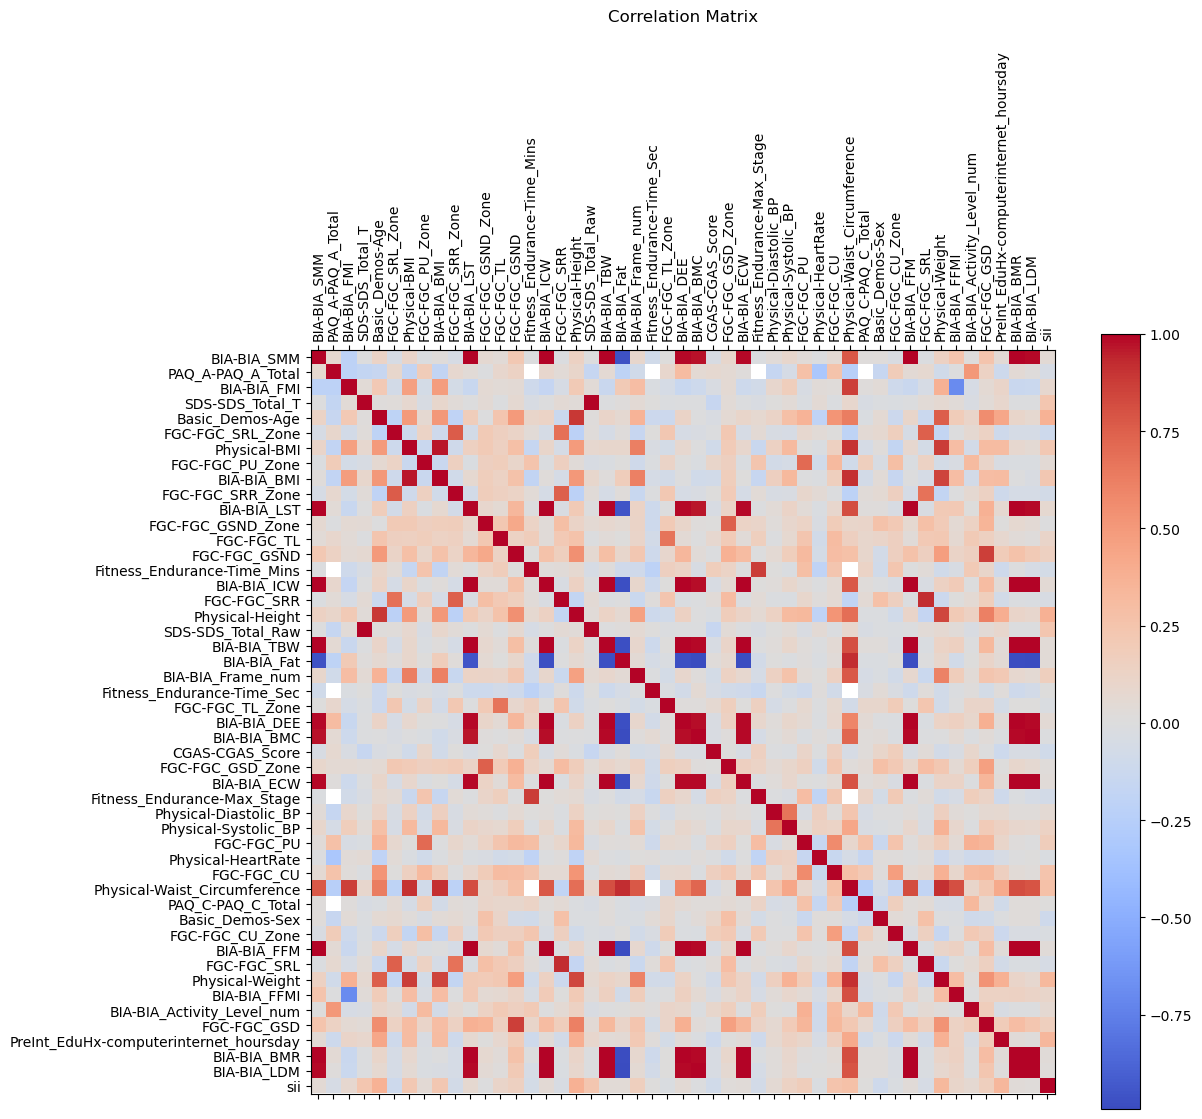

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your dataset is a DataFrame called `data`
# Select numeric columns only
numeric_data = train.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(correlation_matrix.shape[1]), correlation_matrix.columns, rotation=90)
plt.yticks(range(correlation_matrix.shape[0]), correlation_matrix.index)
plt.title("Correlation Matrix", pad=20)
plt.show()


## Develop Baseline Model

In [14]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import lightgbm as lgb
from concurrent.futures import ThreadPoolExecutor

# Set constants
SEED = 42
epsilon = 1e-6
n_splits = 5

# Define the base path to the data directory
data_dir = '../data/child-mind-institute-problematic-internet-use/'

# Load the CSV files
train_csv_path = os.path.join(data_dir, 'train.csv')
test_csv_path = os.path.join(data_dir, 'test.csv')

train = pd.read_csv(train_csv_path)
test = pd.read_csv(test_csv_path)

# Target variable
train_y = train['sii']
train.drop(columns=['sii'], inplace=True)

# Common columns
common_columns = list(set(train.columns).intersection(set(test.columns)))
train = train[common_columns]
test = test[common_columns]

# Add back target
train['sii'] = train_y

# Ensure valid rows
train = train.query("~sii.isna()")

# Time series feature extraction
series_train_dir = '../data/child-mind-institute-problematic-internet-use/series_train.parquet/'
series_test_dir = '../data/child-mind-institute-problematic-internet-use/series_test.parquet/'

def process_file_with_auc(filename, dirname):
    file_path = os.path.join(dirname, filename, 'part-0.parquet')
    try:
        df = pd.read_parquet(file_path)
        df.drop('step', axis=1, inplace=True, errors='ignore')

        # Calculate AUC for specific numeric columns
        auc_enmo = np.trapz(df['enmo'].fillna(0))
        auc_light = np.trapz(df['light'].fillna(0))
        auc_anglez = np.trapz(df['anglez'].fillna(0))

        # Return summary and ID
        summary = {
            'mean_enmo': df['enmo'].mean(),
            'std_enmo': df['enmo'].std(),
            'mean_light': df['light'].mean(),
            'std_light': df['light'].std(),
            'wear_time_percentage': 100 * (1 - df['non-wear_flag'].mean()),
            'anglez_mean': df['anglez'].mean(),
            'anglez_std': df['anglez'].std(),
            'auc_enmo': auc_enmo,
            'auc_light': auc_light,
            'auc_anglez': auc_anglez
        }
        return summary, filename.split('=')[1]
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

def valid_id_dirs(dirname):
    ids = os.listdir(dirname)
    return [f for f in ids if not f.startswith('.') and os.path.isdir(os.path.join(dirname, f))]

def load_time_series_with_auc(dirname):
    ids = valid_id_dirs(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file_with_auc(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*[res for res in results if res[0] is not None])
    df = pd.DataFrame(stats)
    df['id'] = indexes
    return df

time_series_train_summary = load_time_series_with_auc(series_train_dir)
time_series_test_summary = load_time_series_with_auc(series_test_dir)

train = pd.merge(train, time_series_train_summary, on='id', how='left')
test = pd.merge(test, time_series_test_summary, on='id', how='left')

# Exclude target column from numeric and categorical columns
shared_columns = list(set(train.columns).intersection(set(test.columns)))

numeric_columns = train[shared_columns].select_dtypes(include=['number']).columns
categorical_columns = train[shared_columns].select_dtypes(include=['object', 'category']).columns

# Fill missing values for numeric columns with median
train[numeric_columns] = train[numeric_columns].fillna(train[numeric_columns].median())
test[numeric_columns] = test[numeric_columns].fillna(test[numeric_columns].median())

# Fill missing values for categorical columns with mode
train[categorical_columns] = train[categorical_columns].fillna(train[categorical_columns].mode().iloc[0])
test[categorical_columns] = test[categorical_columns].fillna(test[categorical_columns].mode().iloc[0])

print("Missing values handled successfully.")

### Additional Feature Engineering
# Include AUC-based features
print("\nApplying AUC-based feature engineering...")
train['auc_enmo_light_ratio'] = train['auc_enmo'] / (train['auc_light'] + epsilon)
test['auc_enmo_light_ratio'] = test['auc_enmo'] / (test['auc_light'] + epsilon)

train['auc_anglez_enmo_ratio'] = train['auc_anglez'] / (train['auc_enmo'] + epsilon)
test['auc_anglez_enmo_ratio'] = test['auc_anglez'] / (test['auc_enmo'] + epsilon)

####

# Prepare for modeling
X = train.drop(columns=['id', 'sii'])
y = train['sii']
X_test = test.drop(columns=['id'])

# Handle categorical columns
categorical_columns = [col for col in X.columns if X[col].dtype == 'object']
for col in categorical_columns:
    X[col] = X[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Quadratic Weighted Kappa Function
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

# Train Baseline Model with CV and Evaluate QWK
print("\nTraining baseline model with cross-validation...")
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
oof_predictions = np.zeros(len(train))

model = lgb.LGBMRegressor(
    learning_rate=0.05,
    n_estimators=100,  # Fixed number of trees
    max_depth=-1,  # No maximum depth
    random_state=SEED
)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(X_train, y_train)
    val_predictions = model.predict(X_val)
    oof_predictions[val_idx] = val_predictions

# Round predictions to nearest integer
rounded_oof_predictions = np.round(oof_predictions).astype(int)

# Evaluate QWK
baseline_qwk = quadratic_weighted_kappa(y, rounded_oof_predictions)
print(f"Baseline QWK (Cross-Validation): {baseline_qwk:.4f}")


100%|██████████| 2/2 [00:00<00:00, 112.44it/s]


Missing values handled successfully.

Applying AUC-based feature engineering...

Training baseline model with cross-validation...
Training fold 1/5...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8859
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 70
[LightGBM] [Info] Start training from score 0.579982
Training fold 2/5...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8930
[LightGBM] [Info] Number of data points in the train set: 2189, number of used features: 70
[LightGBM] [Info] Start training from score 0.581087
Training fold 3/5...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001150 seconds.
You can set `force_ro

## Optimal Model

Tune hyperparameters with optuna - optimising the QWK and using area under the curve of time-series features.

In [15]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from scipy.optimize import minimize
import lightgbm as lgb
from concurrent.futures import ThreadPoolExecutor


# Set constants
SEED = 42
n_splits = 5
epsilon = 1e-6
# Define the base path to the data directory
data_dir = '../data/child-mind-institute-problematic-internet-use/'

# Load the CSV files
train_csv_path = os.path.join(data_dir, 'train.csv')
test_csv_path = os.path.join(data_dir, 'test.csv')

train = pd.read_csv(train_csv_path)
test = pd.read_csv(test_csv_path)

# Target variable
train_y = train['sii']
train.drop(columns=['sii'], inplace=True)

# Common columns
common_columns = list(set(train.columns).intersection(set(test.columns)))
train = train[common_columns]
test = test[common_columns]

# Add back target
train['sii'] = train_y

# Ensure valid rows
train = train.query("~sii.isna()")

# Time series feature extraction
series_train_dir = '../data/child-mind-institute-problematic-internet-use/series_train.parquet/'
series_test_dir = '../data/child-mind-institute-problematic-internet-use/series_test.parquet/'

def process_file_with_auc(filename, dirname):
    file_path = os.path.join(dirname, filename, 'part-0.parquet')
    try:
        df = pd.read_parquet(file_path)
        df.drop('step', axis=1, inplace=True, errors='ignore')

        # Calculate AUC for specific numeric columns
        auc_enmo = np.trapz(df['enmo'].fillna(0))
        auc_light = np.trapz(df['light'].fillna(0))
        auc_anglez = np.trapz(df['anglez'].fillna(0))

        # Return summary and ID
        summary = {
            'mean_enmo': df['enmo'].mean(),
            'std_enmo': df['enmo'].std(),
            'mean_light': df['light'].mean(),
            'std_light': df['light'].std(),
            'wear_time_percentage': 100 * (1 - df['non-wear_flag'].mean()),
            'anglez_mean': df['anglez'].mean(),
            'anglez_std': df['anglez'].std(),
            'auc_enmo': auc_enmo,
            'auc_light': auc_light,
            'auc_anglez': auc_anglez
        }
        return summary, filename.split('=')[1]
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, None

def valid_id_dirs(dirname):
    ids = os.listdir(dirname)
    return [f for f in ids if not f.startswith('.') and os.path.isdir(os.path.join(dirname, f))]

def load_time_series_with_auc(dirname):
    ids = valid_id_dirs(dirname)
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file_with_auc(fname, dirname), ids), total=len(ids)))
    stats, indexes = zip(*[res for res in results if res[0] is not None])
    df = pd.DataFrame(stats)
    df['id'] = indexes
    return df

time_series_train_summary = load_time_series_with_auc(series_train_dir)
time_series_test_summary = load_time_series_with_auc(series_test_dir)

train = pd.merge(train, time_series_train_summary, on='id', how='left')
test = pd.merge(test, time_series_test_summary, on='id', how='left')

# Exclude target column from numeric and categorical columns
shared_columns = list(set(train.columns).intersection(set(test.columns)))

numeric_columns = train[shared_columns].select_dtypes(include=['number']).columns
categorical_columns = train[shared_columns].select_dtypes(include=['object', 'category']).columns

# Fill missing values for numeric columns with median
train[numeric_columns] = train[numeric_columns].fillna(train[numeric_columns].median())
test[numeric_columns] = test[numeric_columns].fillna(test[numeric_columns].median())

# Fill missing values for categorical columns with mode
train[categorical_columns] = train[categorical_columns].fillna(train[categorical_columns].mode().iloc[0])
test[categorical_columns] = test[categorical_columns].fillna(test[categorical_columns].mode().iloc[0])

print("Missing values handled successfully.")

### Additional Feature Engineering
# Include AUC-based features
print("\nApplying AUC-based feature engineering...")
train['auc_enmo_light_ratio'] = train['auc_enmo'] / (train['auc_light'] + epsilon)
test['auc_enmo_light_ratio'] = test['auc_enmo'] / (test['auc_light'] + epsilon)

train['auc_anglez_enmo_ratio'] = train['auc_anglez'] / (train['auc_enmo'] + epsilon)
test['auc_anglez_enmo_ratio'] = test['auc_anglez'] / (test['auc_enmo'] + epsilon)

####

# Prepare for modeling
X = train.drop(columns=['id', 'sii'])
y = train['sii']
X_test = test.drop(columns=['id'])

# Handle categorical columns
categorical_columns = [col for col in X.columns if X[col].dtype == 'object']
for col in categorical_columns:
    X[col] = X[col].astype('category')
    X_test[col] = X_test[col].astype('category')



100%|██████████| 2/2 [00:00<00:00, 104.12it/s]

Missing values handled successfully.

Applying AUC-based feature engineering...


In [16]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from scipy.optimize import minimize
import optuna
from tqdm import tqdm


# Define Quadratic Weighted Kappa and Threshold Functions
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

# Optuna Objective Function
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'random_state': 42,
        'verbosity': -1
    }
    
    # Early stopping rounds as a tunable parameter
    early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 10, 60)
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    oof_predictions = np.zeros(len(train))
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='rmse',
            callbacks=[
                lgb.early_stopping(early_stopping_rounds, verbose=False)
            ]
        )
        
        val_predictions = model.predict(X_val)
        oof_predictions[val_idx] = val_predictions
    
    thresholds = [0.5, 1.5, 2.5]
    result = minimize(evaluate_predictions, thresholds, args=(y, oof_predictions), method='Nelder-Mead')
    optimized_thresholds = result.x
    tuned_predictions = threshold_Rounder(oof_predictions, optimized_thresholds)
    return quadratic_weighted_kappa(y, tuned_predictions)

# Hyperparameter Optimization with Optuna
print("Optimizing hyperparameters with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)

# Train Final Model with Optimized Parameters
best_params = study.best_params
best_params['verbosity'] = -1

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
oof_predictions = np.zeros(len(train))
test_predictions = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = lgb.LGBMRegressor(**best_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[
            lgb.early_stopping(best_params['early_stopping_rounds'], verbose=False)
        ]
    )
    
    val_predictions = model.predict(X_val)
    oof_predictions[val_idx] = val_predictions
    test_predictions += model.predict(X_test) / skf.n_splits

# Optimize Thresholds
thresholds = [0.5, 1.5, 2.5]
result = minimize(evaluate_predictions, thresholds, args=(y, oof_predictions), method='Nelder-Mead')
optimized_thresholds = result.x
tuned_oof_predictions = threshold_Rounder(oof_predictions, optimized_thresholds)
tuned_test_predictions = threshold_Rounder(test_predictions, optimized_thresholds)

optimized_qwk = quadratic_weighted_kappa(y, tuned_oof_predictions)
print(f"Optimized QWK: {optimized_qwk:.4f}")

/Users/lukeday/miniforge3/envs/KaggleCMI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-24 02:06:05,023] A new study created in memory with name: no-name-593db5e1-5d2a-4195-92f1-ea0ffefe1993


Optimizing hyperparameters with Optuna...


[I 2024-11-24 02:06:07,435] Trial 0 finished with value: 0.47179854922053177 and parameters: {'learning_rate': 0.020939525908042753, 'n_estimators': 152, 'max_depth': 14, 'num_leaves': 131, 'min_data_in_leaf': 27, 'feature_fraction': 0.613175445126882, 'bagging_fraction': 0.9194142156802989, 'bagging_freq': 4, 'lambda_l1': 8.49268976813915, 'lambda_l2': 2.1459213777680706, 'early_stopping_rounds': 59}. Best is trial 0 with value: 0.47179854922053177.
[I 2024-11-24 02:06:08,419] Trial 1 finished with value: 0.36281923385133685 and parameters: {'learning_rate': 0.016465753365312162, 'n_estimators': 162, 'max_depth': 3, 'num_leaves': 62, 'min_data_in_leaf': 34, 'feature_fraction': 0.9389346730282192, 'bagging_fraction': 0.7860674836249224, 'bagging_freq': 2, 'lambda_l1': 1.9300681262065478, 'lambda_l2': 8.099897248146693, 'early_stopping_rounds': 35}. Best is trial 0 with value: 0.47179854922053177.
[I 2024-11-24 02:06:09,185] Trial 2 finished with value: 0.4662167850736022 and parameters

Best hyperparameters: {'learning_rate': 0.03310864223335214, 'n_estimators': 397, 'max_depth': 16, 'num_leaves': 105, 'min_data_in_leaf': 50, 'feature_fraction': 0.8182137621410703, 'bagging_fraction': 0.8305641324103737, 'bagging_freq': 3, 'lambda_l1': 3.6319245979486157, 'lambda_l2': 3.4993111304695717, 'early_stopping_rounds': 42}
Optimized QWK: 0.4782


### Refit model with optimal hyperparameters to full dataset

In [17]:
# Refit on full data without early stopping
print("\nRefitting model on full training data...")

# Copy best parameters and remove early stopping rounds
final_params = best_params.copy()
final_params.pop('early_stopping_rounds', None)  # Remove early stopping parameter

# Initialize the final model
final_model = lgb.LGBMRegressor(**final_params)

# Fit the model on the full training data
final_model.fit(
    X, y
)

# Predict on test set
final_test_predictions = final_model.predict(X_test)

# Apply optimized thresholds to test predictions
final_test_predictions_rounded = threshold_Rounder(final_test_predictions, optimized_thresholds)

# Prepare submission
submission = pd.DataFrame({
    'id': test['id'],
    'sii': final_test_predictions_rounded.astype(int)
})

# Save submission to CSV
submission_file_path = 'submission.csv'
submission.to_csv(submission_file_path, index=False)
print(f"Submission file saved to {submission_file_path}")



Refitting model on full training data...
Submission file saved to submission.csv
